In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import IPython.display as d

# === Folder to config mapping ===
folder_map = {
    "fl": "FL",
    "fl_he": "FL + HE",
    "fl_he_dp": "FL + HE + DP",
    "fl_dp": "FL + DP"
}

# === Load logs ===
base_dir = "."  # Current working directory
all_data = {}

for folder, config_name in folder_map.items():
    full_path = os.path.join(base_dir, folder)
    csv_files = sorted([
        f for f in os.listdir(full_path)
        if f.startswith("server_log_") and f.endswith(".csv")
    ])
    
    runs = []
    for file in csv_files:
        match = re.search(r"r(\d+)", file)
        if match:
            run_number = int(match.group(1))
            df = pd.read_csv(os.path.join(full_path, file))
            df["Run"] = run_number
            runs.append(df)
    
    all_data[config_name] = runs

# === Full Data Dump ===
"""
print("=== FULL DATA DUMP: ALL RUNS ===")
for config, runs in all_data.items():
    print(f"\n######## {config} ########")
    for i, df in enumerate(runs, start=1):
        print(f"\n--- {config} | Run {i} ---")
        d.display(df)
"""

/tmp/ipykernel_123442/2867411660.py:41: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(f1_array, axis=0),
/home/jmulvany/Thesis_BU/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_123442/2867411660.py:47: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(time_array, axis=0),


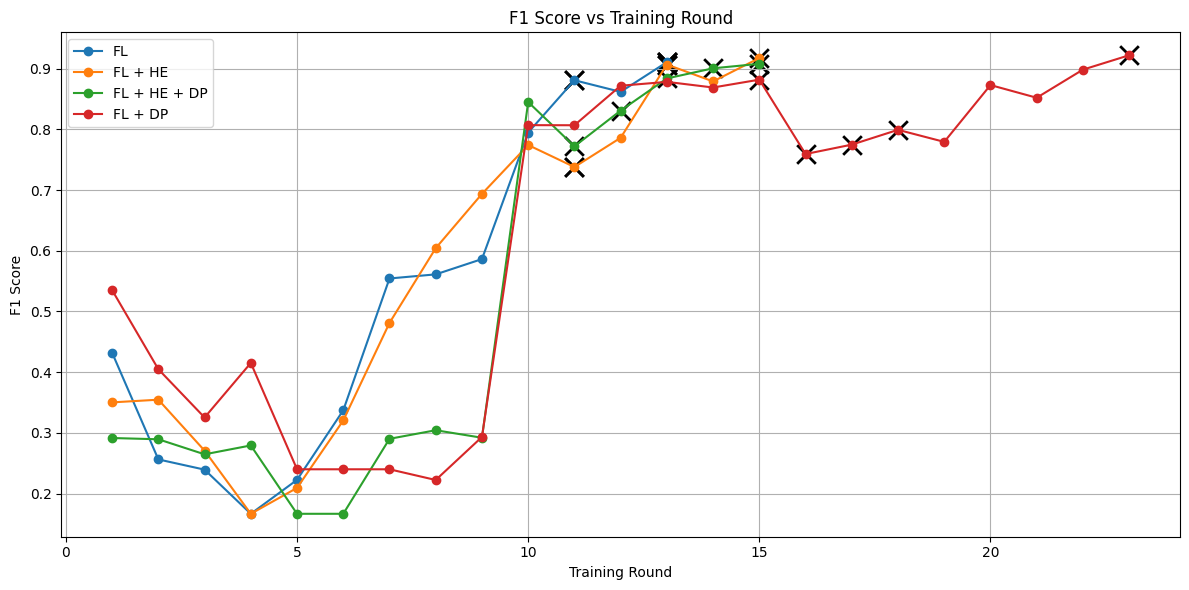

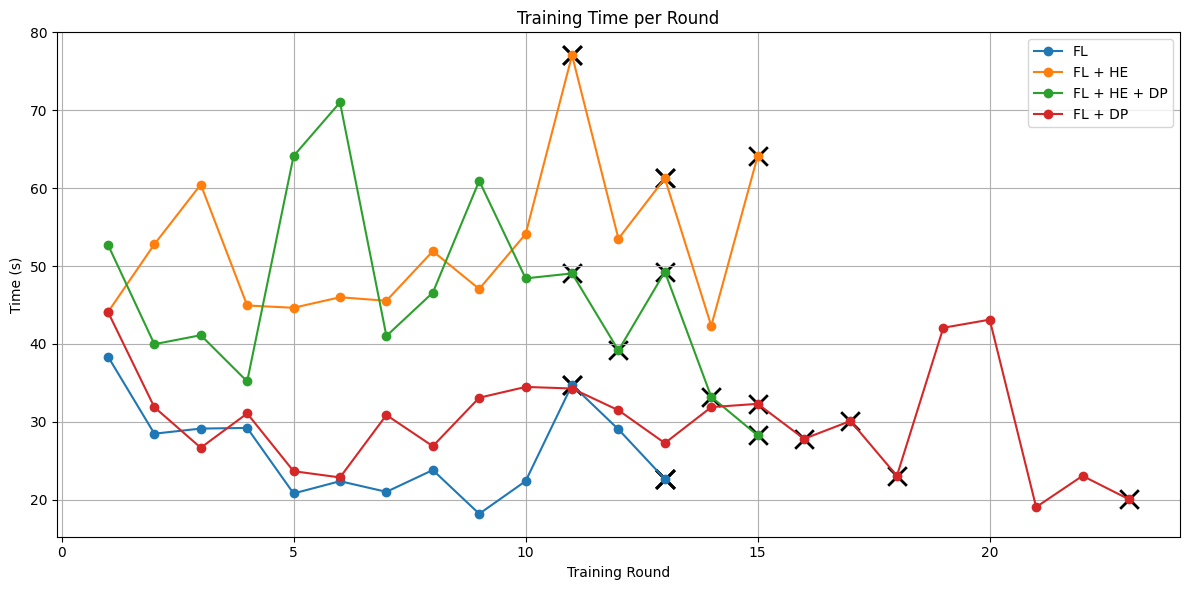

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# === Toggle STD DEV Visualization ===
SHOW_STD_DEV = False      # Set to False to hide all std visualization
USE_ERROR_BARS = True      # If SHOW_STD_DEV is True, choose between error bars or shaded area

# --- Setup ---
max_rounds = 0
f1_stats = {}
time_stats = {}

# Compute max rounds and gather data
for config, runs in all_data.items():
    max_rounds = max(max_rounds, max(len(df) for df in runs if not df.empty))

for config, runs in all_data.items():
    f1_matrix = []
    time_matrix = []
    stop_rounds = []

    for df in runs:
        if df.empty:
            continue
        f1_series = df["F1 Score"].values
        time_series = df["Round Duration (s)"].values
        stop_rounds.append(len(f1_series))

        f1_padded = np.full(max_rounds, np.nan)
        time_padded = np.full(max_rounds, np.nan)
        f1_padded[:len(f1_series)] = f1_series
        time_padded[:len(time_series)] = time_series

        f1_matrix.append(f1_padded)
        time_matrix.append(time_padded)

    f1_array = np.vstack(f1_matrix)
    time_array = np.vstack(time_matrix)

    f1_stats[config] = {
        "mean": np.nanmean(f1_array, axis=0),
        "std": np.nanstd(f1_array, axis=0),
        "stop_rounds": stop_rounds
    }

    time_stats[config] = {
        "mean": np.nanmean(time_array, axis=0),
        "std": np.nanstd(time_array, axis=0),
        "stop_rounds": stop_rounds
    }

rounds = np.arange(1, max_rounds + 1)
colors = plt.cm.tab10.colors

# === F1 Score Plot ===
plt.figure(figsize=(12, 6))
for idx, (config, stats) in enumerate(f1_stats.items()):
    mean = stats["mean"]
    std = stats["std"]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=colors[idx])
        else:
            plt.plot(rounds, mean, label=config, color=colors[idx])
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=colors[idx])
    else:
        plt.plot(rounds, mean, label=config, color=colors[idx], marker='o')

    for r in stats["stop_rounds"]:
        if r <= len(mean):
            plt.scatter(r, mean[r-1], marker='x', color='black', s=180, linewidths=2)

plt.title("F1 Score vs Training Round")
plt.xlabel("Training Round")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Training Time Plot ===
plt.figure(figsize=(12, 6))
for idx, (config, stats) in enumerate(time_stats.items()):
    mean = stats["mean"]
    std = stats["std"]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=colors[idx])
        else:
            plt.plot(rounds, mean, label=config, color=colors[idx])
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=colors[idx])
    else:
        plt.plot(rounds, mean, label=config, color=colors[idx], marker='o')

    for r in stats["stop_rounds"]:
        if r <= len(mean):
            plt.scatter(r, mean[r-1], marker='x', color='black', s=180, linewidths=2)

plt.title("Training Time per Round")
plt.xlabel("Training Round")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
